In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import resample

import re
from urllib.parse import urlparse

# STEP ONE DATA PRE PROCESSING

In [22]:
dataset_path = "../data/phishing_site_urls.csv"

# Check if the file exists

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

# else we load the file

df = pd.read_csv(dataset_path)

# Quick look at the data
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Dataset shape: (549346, 2)
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB
None
                               URL   Label
count                       549346  549346
unique                      507195       2
top     jhomitevd2abj3fk.onion.to/    good
freq                            52  392924


In [23]:
# EDA
print(df.isnull().sum())
print(df['Label'].value_counts())


URL      0
Label    0
dtype: int64
Label
good    392924
bad     156422
Name: count, dtype: int64


# Step TWO : Data Cleaning & Balancing

In [24]:
print("Initial dataset shape:", df.shape)
print("Class distribution:\n", df['Label'].value_counts())

# Removing duplicates 
df = df.drop_duplicates(subset=['URL'])
print("Duplicates:", df.duplicated().sum())
print("null values:", df.isnull().sum().sum())
print("Replacing outliers with mean values")


# replace outliers with mean values

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    # skip the target label column
    if col.lower() == 'label':
        continue

    # compute IQR and replace outliers with the column mean
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mean_value = df[col].mean()

    # ensure column is float for comparison and assignment
    df[col] = df[col].astype(float)
    df.loc[(df[col] < lower) | (df[col] > upper), col] = mean_value
print("Shape after removing duplicates:", df.shape)

# Handling missing URLs
missing_count = df['URL'].isnull().sum()
print("Missing URLs:", missing_count)
df = df.dropna(subset=['URL'])
print("Shape after dropping missing URLs:", df.shape)

# Encode labels to numeric
# 'good' → 0, 'bad' → 1
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})



# Check class balance
print("Class distribution before balancing:\n", df['Label'].value_counts())

# Suppose you want majority class reduced to, e.g., 70% of minority class instead of 1:1
df_majority = df[df['Label'] == 0]
df_minority = df[df['Label'] == 1]

# Define desired ratio: e.g., majority = 1.5x minority
desired_ratio = 1.5
n_majority_new = int(len(df_minority) * desired_ratio)

df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=n_majority_new,  # reduced majority class
    random_state=42
)

# Combine with minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", df_balanced.shape)
print("Class distribution after balancing:\n", df_balanced['Label'].value_counts())


Initial dataset shape: (549346, 2)
Class distribution:
 Label
good    392924
bad     156422
Name: count, dtype: int64
Duplicates: 0
null values: 0
Replacing outliers with mean values
Shape after removing duplicates: (507195, 2)
Missing URLs: 0
Shape after dropping missing URLs: (507195, 2)
Class distribution before balancing:
 Label
0    392897
1    114298
Name: count, dtype: int64
Balanced dataset shape: (285745, 2)
Class distribution after balancing:
 Label
0    171447
1    114298
Name: count, dtype: int64


# STEP THREE FEATURE ENGINEERING

In [6]:
# we basically using a classification model to detect phishing URLs 
# based on the URL features we will extract in the next steps
# we don't need to tokenize the URLs as text data for NLP tasks
# instead we will engineer features from the URLs directly using custom functions

df = df_balanced.copy()

# --- Feature functions ---
def url_length(url):
    return len(url)

def num_dots(url):
    return url.count('.')

def num_hyphens(url):
    return url.count('-')

def num_underscores(url):
    return url.count('_')

def has_at_symbol(url):
    return 1 if '@' in url else 0

def has_tilde(url):
    return 1 if '~' in url else 0

def num_digits(url):
    return sum(c.isdigit() for c in url)

def num_subdomains(url):
    domain = urlparse(url).netloc
    return domain.count('.') if domain else 0

def has_ip_address(url):
    domain = urlparse(url).netloc
    # Simple check: contains only digits and dots (IPv4)
    if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain):
        return 1
    return 0

def https_flag(url):
    return 1 if url.startswith('https://') else 0

# --- Apply feature functions ---
df_features = pd.DataFrame()
df_features['URL_Length'] = df['URL'].apply(url_length)
df_features['Num_Dots'] = df['URL'].apply(num_dots)
df_features['Num_Hyphens'] = df['URL'].apply(num_hyphens)
df_features['Num_Underscores'] = df['URL'].apply(num_underscores)
df_features['Has_At'] = df['URL'].apply(has_at_symbol)
df_features['Has_Tilde'] = df['URL'].apply(has_tilde)
df_features['Num_Digits'] = df['URL'].apply(num_digits)
df_features['Num_Subdomains'] = df['URL'].apply(num_subdomains)
df_features['Has_IP'] = df['URL'].apply(has_ip_address)
df_features['HTTPS'] = df['URL'].apply(https_flag)

# Target variable
y = df['Label']

print("Feature matrix shape:", df_features.shape)
print("Target shape:", y.shape)
df_features.head()

Feature matrix shape: (285745, 10)
Target shape: (285745,)


,URL_Length,Num_Dots,Num_Hyphens,Num_Underscores,Has_At,Has_Tilde,Num_Digits,Num_Subdomains,Has_IP,HTTPS
0,57,2,0,0,0,0,19,0,0,0
1,50,2,0,0,0,0,5,0,0,0
2,36,2,0,0,0,0,1,0,0,0
3,36,2,1,0,0,0,0,0,0,0
4,87,2,0,13,0,0,0,0,0,0


# STEP FOUR APPLYING THE MODEL

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import accuracy_score

🔵 Accuracy: 0.7795

🔵 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     34289
           1       0.73      0.71      0.72     22860

    accuracy                           0.78     57149
   macro avg       0.77      0.77      0.77     57149
weighted avg       0.78      0.78      0.78     57149



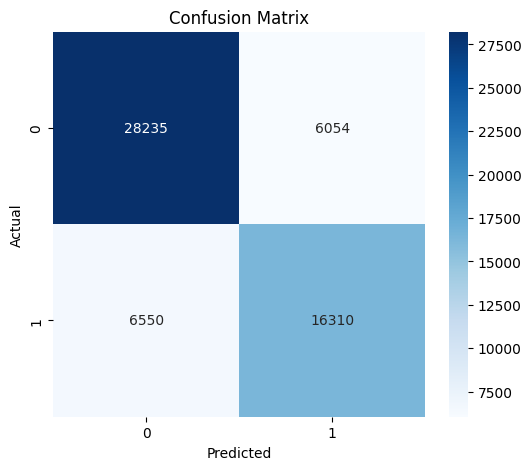

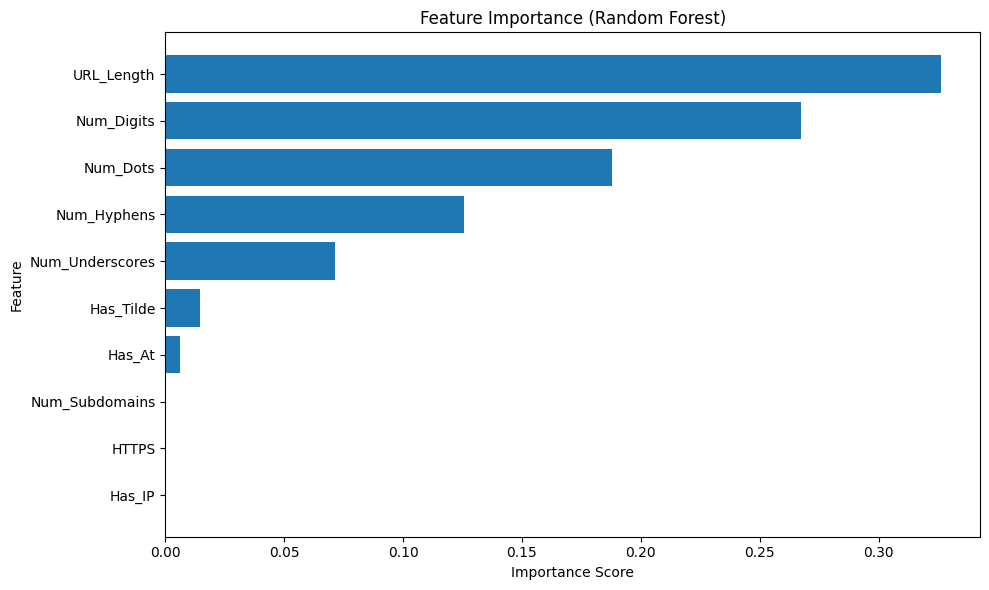

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix
)

# ---------------------------
# 1. DATA SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ---------------------------
# 2. SCALING
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 3. MODEL TRAINING
# ---------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

# ---------------------------
# 4. METRICS
# ---------------------------
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"🔵 Accuracy: {acc:.4f}")
print("\n🔵 Classification Report:\n")
print(report)

# ---------------------------
# 5. CONFUSION MATRIX PLOT
# ---------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------
# 6. FEATURE IMPORTANCE PLOT
# ---------------------------
importances = rf.feature_importances_
feature_names = X_train.columns

sorted_idx = importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [14]:
import joblib
import os
from IPython.display import FileLink, display

# ---------------------------
# Paths to save files
# ---------------------------
BASE_DIR = "../backend/app/models"  # relative path from notebook
os.makedirs(BASE_DIR, exist_ok=True)

model_path = os.path.join(BASE_DIR, "phishing_model.pkl")
scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
X_test_scaled_path = os.path.join(BASE_DIR, "X_test_scaled.pkl")
y_test_path = os.path.join(BASE_DIR, "y_test.pkl")

# ---------------------------
# Save model, scaler, and test sets
# ---------------------------
joblib.dump(rf, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(X_test_scaled, X_test_scaled_path)
joblib.dump(y_test, y_test_path)

print("✅ Files saved successfully in ../backend/app/models!")

# ---------------------------
# Create download links
# ---------------------------
display(FileLink(model_path, result_html_prefix="Download Model: "))
display(FileLink(scaler_path, result_html_prefix="Download Scaler: "))
display(FileLink(X_test_scaled_path, result_html_prefix="Download X_test_scaled: "))
display(FileLink(y_test_path, result_html_prefix="Download y_test: "))

✅ Files saved successfully in ../backend/app/models!


/home/ray/Desktop/workspace/url_detector/backend/app/models/phishing_model.pkl

/home/ray/Desktop/workspace/url_detector/backend/app/models/scaler.pkl

/home/ray/Desktop/workspace/url_detector/backend/app/models/X_test_scaled.pkl

/home/ray/Desktop/workspace/url_detector/backend/app/models/y_test.pkl

🔵 Logistic Regression Performance:
Accuracy: 0.7165

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79     34289
           1       0.72      0.47      0.57     22860

    accuracy                           0.72     57149
   macro avg       0.72      0.68      0.68     57149
weighted avg       0.72      0.72      0.70     57149

Confusion Matrix:
[[30163  4126]
 [12077 10783]]


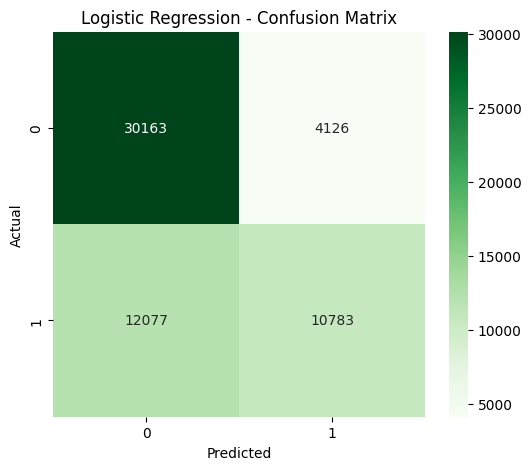

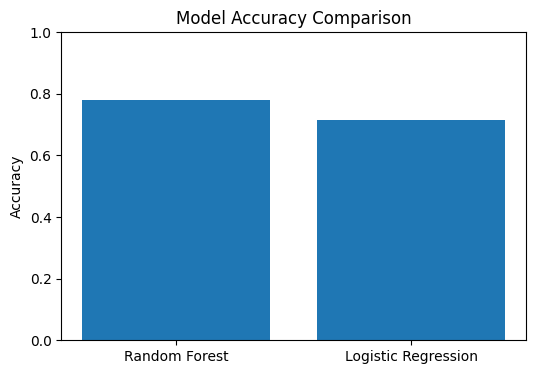


📊 Accuracy Comparison
Random Forest Accuracy:      0.7795
Logistic Regression Accuracy: 0.7165


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. TRAIN LOGISTIC REGRESSION
# ---------------------------
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test_scaled)

# ---------------------------
# 2. METRICS
# ---------------------------
log_acc = accuracy_score(y_test, y_pred_log)
cm_log = confusion_matrix(y_test, y_pred_log)

print("🔵 Logistic Regression Performance:")
print(f"Accuracy: {log_acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:")
print(cm_log)

# ---------------------------
# 3. CONFUSION MATRIX PLOT
# ---------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log, annot=True, cmap="Greens", fmt="d")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ---------------------------
# 4. MODEL COMPARISON
# ---------------------------
rf_acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.bar(["Random Forest", "Logistic Regression"], [rf_acc, log_acc])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

print("\n📊 Accuracy Comparison")
print(f"Random Forest Accuracy:      {rf_acc:.4f}")
print(f"Logistic Regression Accuracy: {log_acc:.4f}")



📊 Detailed Comparison Table:

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0        Random Forest  0.779454   0.729297  0.713473  0.721298  0.863056
1  Logistic Regression  0.716478   0.723254  0.471697  0.570997  0.762799


<Figure size 1000x600 with 0 Axes>

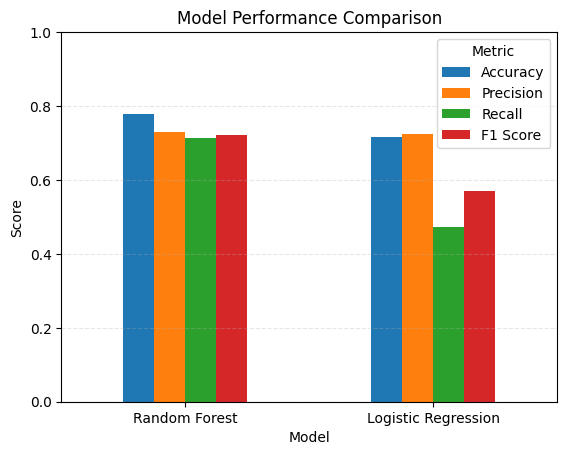

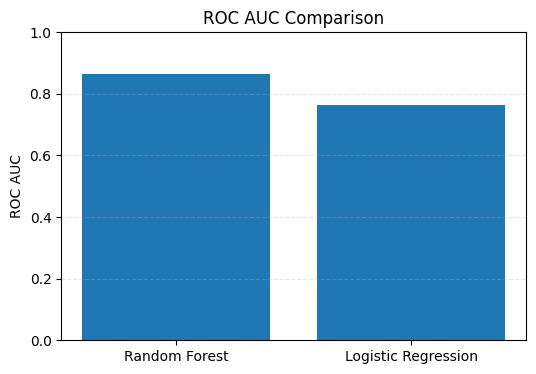

In [17]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Compute metrics for both models
# ---------------------------

def evaluate_model(name, y_true, y_pred, y_proba=None):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba) if y_proba is not None else None
    }

# Random Forest metrics
rf_results = evaluate_model(
    "Random Forest",
    y_test,
    y_pred,
    rf.predict_proba(X_test_scaled)[:, 1]
)

# Logistic Regression metrics
log_results = evaluate_model(
    "Logistic Regression",
    y_test,
    y_pred_log,
    log_reg.predict_proba(X_test_scaled)[:, 1]
)

# ---------------------------
# Combine into a DataFrame
# ---------------------------

results_df = pd.DataFrame([rf_results, log_results])
print("\n📊 Detailed Comparison Table:\n")
print(results_df)

# ---------------------------
# Bar Plot Comparison (Accuracy, Precision, Recall, F1)
# ---------------------------

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]

plt.figure(figsize=(10, 6))
results_df.set_index("Model")[metrics_to_plot].plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

# ---------------------------
# ROC AUC comparison
# ---------------------------

plt.figure(figsize=(6, 4))
plt.bar(results_df["Model"], results_df["ROC AUC"])
plt.title("ROC AUC Comparison")
plt.ylabel("ROC AUC")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


In [18]:
# Cross-validation

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# --------------------------------------
# Create a pipeline: Scaling + Random Forest
# --------------------------------------
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

# --------------------------------------
# Stratified 5-Fold Cross Validation
# --------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    rf_pipeline,
    df_features,  # X full dataset
    y,            # labels
    cv=cv,
    scoring=[
        "accuracy",
        "precision",
        "recall",
        "f1",
        "roc_auc"
    ],
    return_train_score=False,
    n_jobs=-1
)

# --------------------------------------
# Print mean scores
# --------------------------------------
print("\n📊 Random Forest Cross-Validation Results (5 folds):")
print(f"Accuracy:      {scores['test_accuracy'].mean():.4f}")
print(f"Precision:     {scores['test_precision'].mean():.4f}")
print(f"Recall:        {scores['test_recall'].mean():.4f}")
print(f"F1 Score:      {scores['test_f1'].mean():.4f}")
print(f"ROC AUC:       {scores['test_roc_auc'].mean():.4f}")

# Optional: print all fold results
print("\n🔍 Fold-by-fold accuracy:", scores['test_accuracy'])



📊 Random Forest Cross-Validation Results (5 folds):
Accuracy:      0.7785
Precision:     0.7273
Recall:        0.7141
F1 Score:      0.7206
ROC AUC:       0.8623

🔍 Fold-by-fold accuracy: [0.77724895 0.77691648 0.77901626 0.77936622 0.78006614]
